In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install atmos-cloud-sim-uj-utils
    from atmos_cloud_sim_uj_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
from PySDM_examples.Singer_Ward import Settings, ParcelSimulation
from PySDM_examples.Singer_Ward.aerosol import AerosolBetaCaryophylleneDark

from atmos_cloud_sim_uj_utils import show_plot
from PySDM.initialisation.sampling import spectral_sampling as spec_sampling
from PySDM.physics import si

import numpy as np
import os
from matplotlib import pyplot
import matplotlib
from joblib import Parallel, delayed

In [3]:
CI = 'CI' in os.environ
CI = True

updraft_list = np.geomspace(0.1, 10, 3 if CI else 10)
forg_list = np.linspace(0.05, 0.95, 3 if CI else 10)
models = ('Constant', 'CompressedFilmOvadnevaite')

In [4]:
def compute(key, settings):
    simulation = ParcelSimulation(settings)
    output = simulation.run()
    output['updraft'] = settings.w
    output['org_fraction'] = settings.aerosol.modes[0]['f_org']
    output['color'] = settings.aerosol.color
    return key, output

print(f'tasks scheduled: {len(models) * len(forg_list) * len(updraft_list)}')
output = dict(Parallel(verbose=10, n_jobs=-1)(
    delayed(compute)("w{:.2f}_f{:.2f}_".format(w,Forg)+model, Settings(
        dz = 1 * si.m, 
        n_sd_per_mode = 50, 
        model = model,
        aerosol = AerosolBetaCaryophylleneDark(Forg=Forg),
        w = w * si.m / si.s,
        spectral_sampling = spec_sampling.ConstantMultiplicity
    ))
    for w in updraft_list
    for Forg in forg_list
    for model in models
))

tasks scheduled: 18


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:  1.7min remaining:   39.7s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:  1.9min remaining:   22.8s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.2min finished


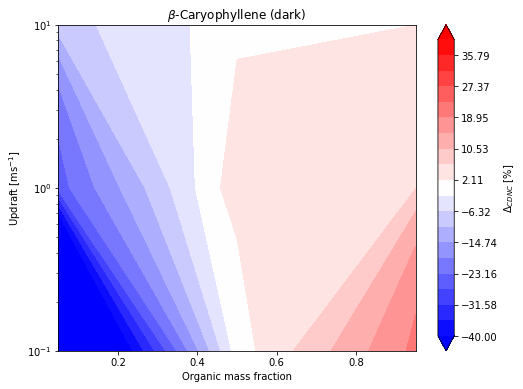

In [5]:
dCDNC = np.zeros((len(updraft_list), len(forg_list)))
for i,w in enumerate(updraft_list):
    for j,Forg in enumerate(forg_list):
        key = "w{:.2f}_f{:.2f}_".format(w,Forg)
        var = 'n_c_cm3'
        z = np.array(output[key+"Constant"]['z'])
        wz = np.where(z == z[-1])[0][0]
        CDNC_film = np.array(output[key+"CompressedFilmOvadnevaite"][var])[wz]
        CDNC_bulk = np.array(output[key+"Constant"][var])[wz]
        dCDNC[i,j] = (CDNC_film - CDNC_bulk) / CDNC_bulk * 100.0

fig, axes = pyplot.subplots(1,1, sharex=True, sharey=True, figsize=(8,6))
ax = axes
ax.set_title("$\\beta$-Caryophyllene (dark)")
levs = np.linspace(-40,40,20)
p = ax.contourf(forg_list, updraft_list, dCDNC, cmap="bwr", extend="both", levels=levs)
ax.set_xlabel("Organic mass fraction")
ax.set_yscale("log")
# ax.set_yticks([0.1,0.5,2,5])
# ax.set_yticklabels(["0.1","0.5","2","5"])
ax.set_ylabel("Updraft [ms$^{-1}$]")
pyplot.colorbar(p, ax=ax, label="$\Delta_{CDNC}$ [%]")
pyplot.rcParams.update({'font.size': 15})
#pyplot.savefig("bCary_dCDNC_OVF_Updraft.png", dpi=200)
pyplot.show()

############################

# dat = np.zeros((len(forg_list)+1, len(updraft_list)+1))
# dat[1:,0] = updraft_list
# dat[0,1:] = forg_list
# dat[1:,1:] = dCDNC
# print(dat)
# np.savetxt("Ryan_parcel_2D.csv", dat, fmt="%.4f", delimiter=',', 
#            header="W (m/s) (left col), Forg (top row), delta CDNC (%) (grid below), -, -, -, -, -, -, -, -", 
#            comments='Forg fractions in first row // Updraft speed in first column // dCDNC in grid\n')